In [1]:
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path

In [2]:
path = Path().cwd().parent.parent

df = pd.read_json(path / "text_performance.jsonl", orient="records", lines=True)
df.head()

,class,score_type,value,level,binary,is_baseline,model_name,split,target_class,type
0,overall,acc,0.60177,overall,1,0,DEPR_ScandiBERT_lr-0.0001_wdecay-0.001_wsteps-...,val,DEPR,text
1,overall,f1_macro,0.60127,overall,1,0,DEPR_ScandiBERT_lr-0.0001_wdecay-0.001_wsteps-...,val,DEPR,text
2,overall,f1_micro,0.60177,overall,1,0,DEPR_ScandiBERT_lr-0.0001_wdecay-0.001_wsteps-...,val,DEPR,text
3,overall,precision_macro,0.604048,overall,1,0,DEPR_ScandiBERT_lr-0.0001_wdecay-0.001_wsteps-...,val,DEPR,text
4,overall,precision_micro,0.60177,overall,1,0,DEPR_ScandiBERT_lr-0.0001_wdecay-0.001_wsteps-...,val,DEPR,text


In [5]:
# only keep id-level
df = df[df["level"] == "id"]

# only plot test scores and f1-macro for now
df_test = df[(df["score_type"] == "f1_macro") & (df["split"] == "test")]

# split into baseline and transformers for plotting
baselines = df_test[df_test["is_baseline"] == 1]
transformers = df_test[df_test["is_baseline"] == 0]

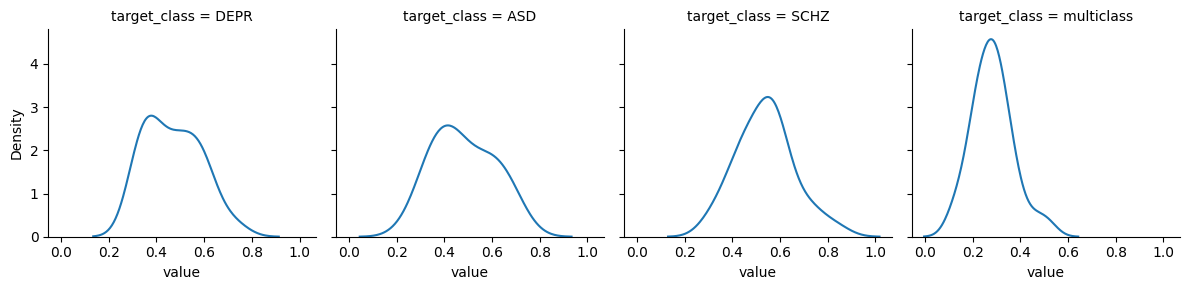

In [8]:
## Plot baseline kde
g = sns.FacetGrid(baselines, col="target_class")
g.map(sns.kdeplot, "value")

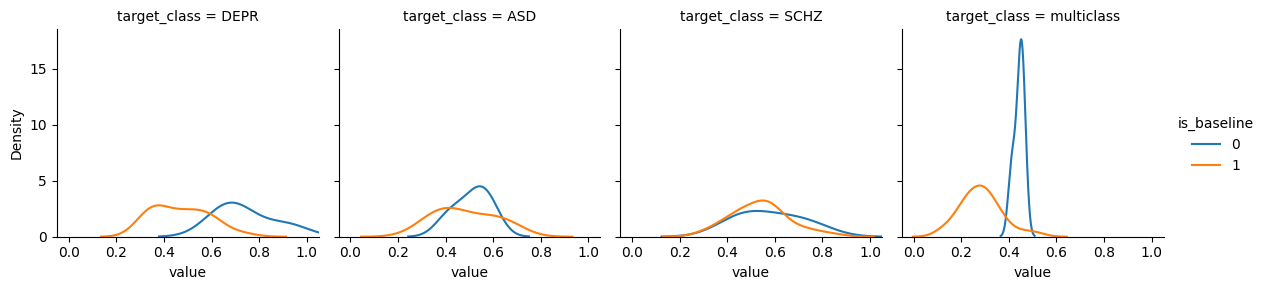

In [13]:
## overlay transformer kde
g = sns.FacetGrid(df_test, col="target_class", hue="is_baseline", xlim=(-0.05, 1.05))
g.map(sns.kdeplot, "value")
g.add_legend()

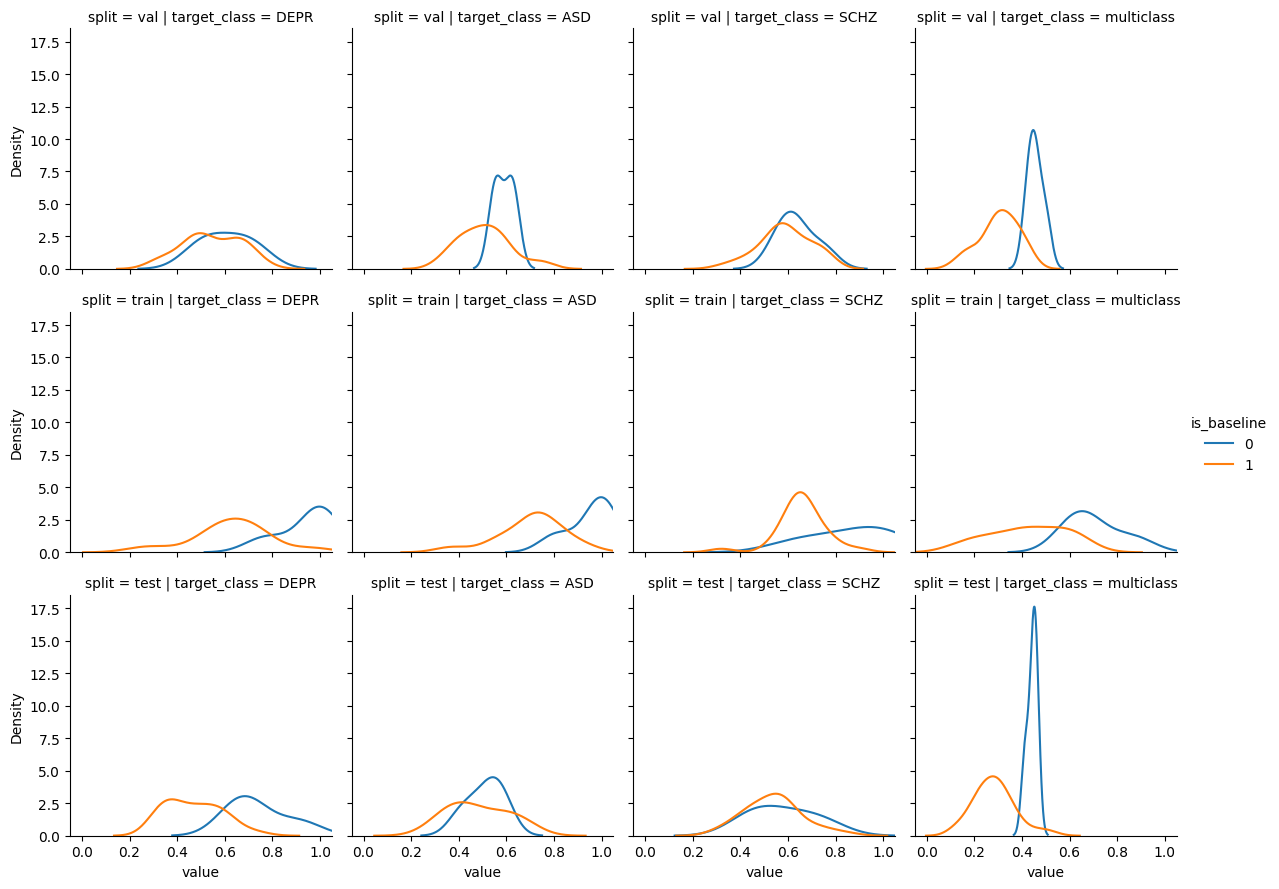

In [18]:
## facet by split too 
g = sns.FacetGrid(df[df["score_type"] == "f1_macro"], col="target_class", row="split", hue="is_baseline", xlim=(-0.05, 1.05))
g.map(sns.kdeplot, "value")
g.add_legend()

In [58]:
# find best multiclass model on test set for both baseline and transformer
def get_best_model(df):
    best_idx = df["value"].astype(float).idxmax()
    return best_idx, df.at[best_idx, "model_name"]


baseline_df = df_test[(df_test["target_class"] == "multiclass") & (df_test["is_baseline"] == 1)]
transformer_df = df_test[(df_test["target_class"] == "multiclass") & (df_test["is_baseline"] == 0)]

best_baseline_idx, best_baseline_name = get_best_model(baseline_df)
best_transformer_idx, best_transformer_name = get_best_model(transformer_df)

print(best_baseline_name, "f1:", df.at[best_baseline_idx, "value"])
print(best_transformer_name, "f1:", df.at[best_transformer_idx, "value"])



tfidf-100 f1: 0.5111111111000001
multiclass_paraphrase-multilingual-MiniLM-L12-v2_lr-1e-05_wdecay-0.001_wsteps-100_nofreeze_batch-16 f1: 0.4608774962


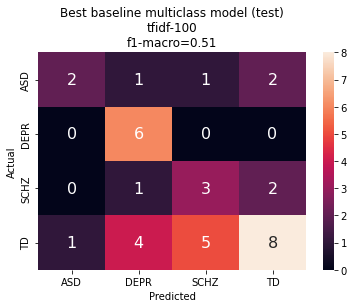

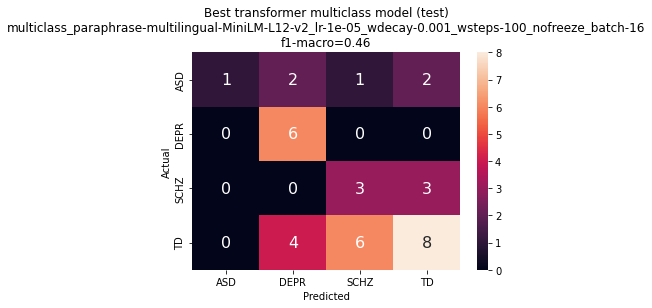

In [92]:
def get_conf_matrix(df, model_name, target_class="multiclass", split="test"):
    df = df[(df["score_type"] == "confusion_matrix") & (df["model_name"] == model_name) & (df["target_class"] == target_class) & (df["split"] == split)]
    conf_mat = df["value"]
    
    if len(conf_mat) > 1:
        raise ValueError("More than 1 confusion matrix returned. Subset better..")
    if target_class == "multiclass":
        idx_mapping = sorted(["TD", "DEPR", "ASD", "SCHZ"])
    else:
        idx_mapping = sorted(["TD", target_class])

    conf_mat = np.stack(df["value"]).squeeze()
    conf_df = pd.DataFrame(conf_mat, index=idx_mapping, columns=idx_mapping)

    return conf_df

def plot_conf_matrix(conf_matrix, title):        
    ax = plt.axes()
    sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16})
    ax.set_title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()    


best_multiclass_baseline_conf = get_conf_matrix(df, best_baseline_name)
title = f"Best baseline multiclass model (test)\n{best_baseline_name}\nf1-macro={round(df.at[best_baseline_idx, 'value'],2)}"

plot_conf_matrix(best_multiclass_baseline_conf, title)


best_multiclass_transformer_conf = get_conf_matrix(df, best_transformer_name)
title = f"Best transformer multiclass model (test)\n{best_transformer_name}\nf1-macro={round(df.at[best_transformer_idx, 'value'],2)}"

plot_conf_matrix(best_multiclass_transformer_conf, title)
